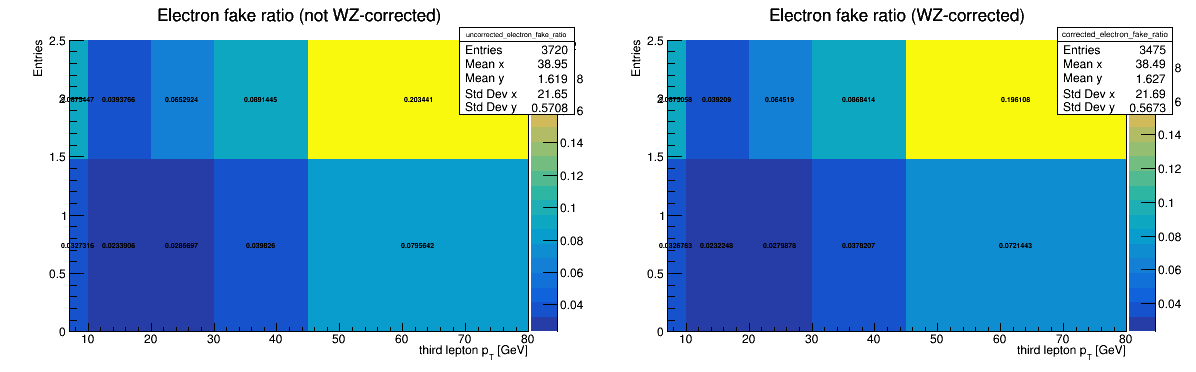

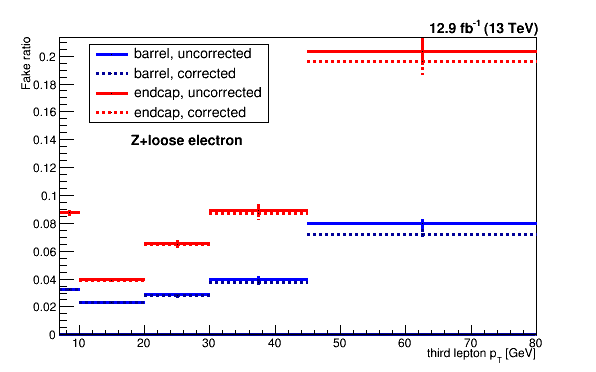

In [17]:
prefix = '/Users/pigard/data/background_estimate/'
post_fix = '_12p9fb'
uncorrected_electrons = calc_eff(prefix, 'REG', post_fix,'_ptl3', 'Zpe', False)
uncorrected_electrons.SetName('uncorrected_electron_fake_ratio')
uncorrected_electrons.SetTitle('Electron fake ratio (not WZ-corrected)')
corrected_electrons = calc_eff(prefix, 'REG', post_fix,'_ptl3', 'Zpe', True)
corrected_electrons.SetName('corrected_electron_fake_ratio')
corrected_electrons.SetTitle('Electron fake ratio (WZ-corrected)')

canvas = rt.TCanvas("test",'test', 1200, 400)
rt.gStyle.SetOptTitle(True)
canvas.Divide(2,1)
canvas.cd(1)
uncorrected_electrons.Draw('COLZTEXT')
canvas.cd(2)
corrected_electrons.Draw('COLZTEXT')
canvas.Draw()

paves = [{'text' :'#scale[0.8]{12.9 fb^{-1} (13 TeV)}', 'pos' : (0.72, 0.91, 1., 0.95)},
        {'text' :'#scale[0.8]{Z+loose electron}', 'pos' : (0.22, 0.61, 1., 0.95)}]
proj_options = {'paves' : paves}
proj_e = make_projections('electron_turn_on', uncorrected_electrons, corrected_electrons, proj_options)

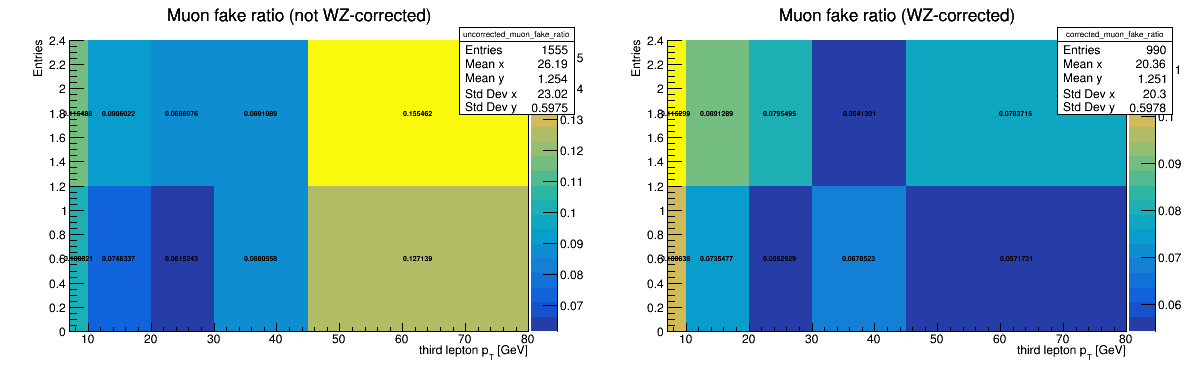

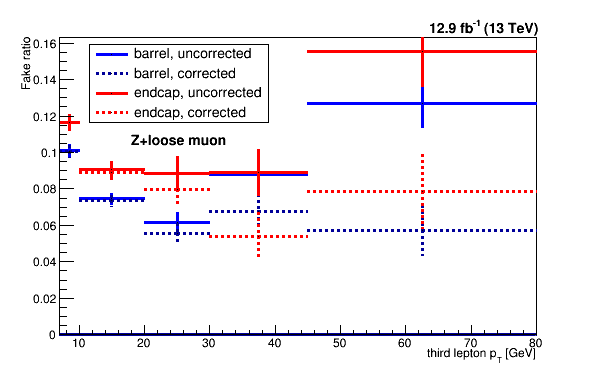

In [18]:
uncorrected_muon = calc_eff(prefix, 'REG', post_fix,'_ptl3', 'Zpm', False)
uncorrected_muon.SetName('uncorrected_muon_fake_ratio')
uncorrected_muon.SetTitle('Muon fake ratio (not WZ-corrected)')
corrected_muon = calc_eff(prefix, 'REG', post_fix,'_ptl3', 'Zpm', True)
corrected_muon.SetName('corrected_muon_fake_ratio')
corrected_muon.SetTitle('Muon fake ratio (WZ-corrected)')

canvas = rt.TCanvas("test",'test', 1200, 400)
rt.gStyle.SetOptTitle(True)
canvas.Divide(2,1)
canvas.cd(1)
uncorrected_muon.Draw('COLZTEXT')
canvas.cd(2)
corrected_muon.Draw('COLZTEXT')
canvas.Draw()
paves = [{'text' :'#scale[0.8]{12.9 fb^{-1} (13 TeV)}', 'pos' : (0.72, 0.91, 1., 0.95)},
        {'text' :'#scale[0.8]{Z+loose muon}', 'pos' : (0.22, 0.61, 1., 0.95)}]
proj_options = {'paves' : paves}
proj_m = make_projections('muon_turn_on', uncorrected_muon, corrected_muon, proj_options)

In [108]:
myfile = root_open('/Users/pigard/data/fake_ratios_v3.root', 'recreate')

In [110]:
uncorrected_electrons.Write()
corrected_electrons.Write()
uncorrected_muon.Write()
corrected_muon.Write()
proj_m.Write()
proj_e.Write()
myfile.Close()

False

In [1]:
from random import random
import ROOT as rt
rt.TH1.AddDirectory(rt.kFALSE)
import math

rt.gStyle.SetOptTitle(0)

def norm_hist(hist, norm = 1.) :
    integral = hist.Integral()
    if integral > 0. : hist.Scale(norm / integral)
    return hist

def scale_hist(hist, scale) :
    hist.Scale(scale)
    return hist

def get_copy(filename, histname) :

    afile = rt.TFile(filename)

    #afile.ls()
    orgHist = afile.Get(histname)
    if orgHist == None :
        print 'Did not find histogram ', histname
        afile.ls()
    else :
        tmp = orgHist.Clone(orgHist.GetName() + '_copy' + str(random()) )
        #tmp.SetDirectory(False)
        afile.Close()
    return tmp

def get_plot(file_name, plot_name, options = None, reference_counts_name = None) :
    if options == None :
        options = {}
    out_plot = get_copy(file_name, plot_name)

    if 'Counters_hist' in options :
        counters = get_copy(file_name, 'Counters')
        sumOfWeights = counters.GetBinContent(40)
        factor = 1.
        if 'xsection' in options :
            xsection = options['xsection']
        return scale_hist(out_plot, xsection * sumOfWeights)

    if 'normalize' in options :
        return norm_hist(out_plot)

    if 'x_section' in options and 'reference_counts_name' is options :
        ref_counts_plot = get_copy(file_name, options['reference_counts_name'])
        return scale_hist(out_plot, options['x_section'] / ref_counts_plot.GetEntries())

    if 'x_section' in options :
        return norm_hist(out_plot, options['x_section'])

    if 'scale' in options :
        return scale_hist(out_plot, options['scale'])

    return out_plot

Welcome to ROOTaaS 6.05/02


In [2]:
import ROOT as rt
from rootpy.plotting import Hist2D
from rootpy.io import root_open
def calc_eff(prefix, tree, proc_postfix, plot, final_state, do_WZ_correction = False) :

    tot = get_plot(prefix + tree + '_CRZL_AllData' + proc_postfix + '.root', 
                          'raw/' + final_state  + plot + '_all')
    passed = get_plot(prefix + tree + '_CRZL_AllData' + proc_postfix + '.root', 
                          'raw/' + final_state  + plot + '_pass')
    
    if do_WZ_correction :
        tot_WZ = get_plot(prefix + tree + '_CRZL_WZTo3LNu' + proc_postfix + '.root', 
                          'raw/' + final_state  + plot + '_all')
        pass_WZ = get_plot(prefix + tree + '_CRZL_WZTo3LNu' + proc_postfix + '.root', 
                          'raw/' + final_state  + plot + '_pass')
    
        tot.Add(tot_WZ, -1.)
        passed.Add(pass_WZ, -1.)
    
    
    #print 'total ', tot.Integral()
    h_result = passed.Divide(tot)
    #print 'count ratio', h_result.Integral()
    
    
    result = passed #ROOT.TGraph(passed)
    return result

/Users/pigard/Envs/default_venv/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [15]:
def make_projections(name, uncorrected, corrected, options = None) :
    if options is None : options = {}
        
    uncorrected_electrons_EB = uncorrected.ProjectionX('_px_EB', 0, 1)
    uncorrected_electrons_EB.SetTitle('barrel, uncorrected')
    uncorrected_electrons_EE = uncorrected.ProjectionX('_px_EE', 2, 2)    
    uncorrected_electrons_EE.SetTitle('endcap, uncorrected')
    corrected_electrons_EB = corrected.ProjectionX('_px_EB', 0, 1)
    corrected_electrons_EB.SetTitle('barrel, corrected')
    corrected_electrons_EE = corrected.ProjectionX('_px_EE', 2, 2)
    corrected_electrons_EE.SetTitle('endcap, corrected')

    canvas = rt.TCanvas(name,'test', 600, 400)
    uncorrected_electrons_EB.SetLineColor(rt.kBlue)
    corrected_electrons_EB.SetLineStyle(rt.kDashed)

    uncorrected_electrons_EE.SetLineColor(rt.kRed)
    corrected_electrons_EE.SetLineColor(rt.kRed)
    corrected_electrons_EE.SetLineStyle(rt.kDashed)

    stack = rt.THStack('tmp1', '')
    stack.Add(uncorrected_electrons_EB)
    stack.Add(corrected_electrons_EB)
    stack.Add(uncorrected_electrons_EE)
    stack.Add(corrected_electrons_EE)



    stack.Draw()
    stack.GetXaxis().SetTitle(uncorrected_electrons_EE.GetXaxis().GetTitle())
    stack.GetYaxis().SetTitle('Fake ratio')#uncorrected_electrons_EE.GetYaxis().GetTitle())
    stack.Draw('NOSTACK')
    leg = canvas.BuildLegend(.15, .67, .45, .88)
    leg.Draw('SAME')
    
    if 'paves' in options :
        for pave in options['paves'] :
            #print 'Preparing pave', pave['text']
            aPave = rt.TLatex(pave['pos'][0],pave['pos'][1],pave['text'])#, pave['pos'][2], pave['pos'][3])#, "blNDC")
            #aPave.SetFillStyle(0)
            #aPave.SetBorderSize(0)
            aPave.SetNDC()
            aPave.Draw()
            #aPave.AddText(pave['text'])
            #aPave.Draw()
            
    canvas.Draw()
    aPave.Draw()   
    canvas.Update()
    
    return canvas